<a href="https://colab.research.google.com/github/DavideScassola/xai-labs/blob/main/./SHAP/exercise_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NHANES I Survival Model

This is a cox proportional hazards model on data from <a href="https://wwwn.cdc.gov/nchs/nhanes/nhanes1">NHANES I</a> with followup mortality data from the <a href="https://wwwn.cdc.gov/nchs/nhanes/nhefs">NHANES I Epidemiologic Followup Study</a>. It is designed to illustrate how SHAP values enable the interpretion of XGBoost models with a clarity traditionally only provided by linear models. We see interesting and non-linear patterns in the data, which suggest the potential of this approach. Keep in mind the data has not yet been checked by us for calibrations to current lab tests and so you should not consider the results as actionable medical insights, but rather a proof of concept. 

In [1]:
import matplotlib.pylab as pl
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
import pandas as pd
import shap

X, y = shap.datasets.nhanesi()

## Load the data

This uses a pre-processed subset of NHANES I data available in the SHAP datasets module.

In [2]:
import shap
X, y = shap.datasets.nhanesi()
X

,sex_isFemale,age,physical_activity,serum_albumin,alkaline_phosphatase,alkaline_phosphatase_isUnacceptable,alkaline_phosphatase_isTestnotdone,SGOT,SGOT_isUnacceptable,SGOT_isTestnotdone,...,urine_hematest_isLarge,urine_hematest_isBlankbutapplicable,sedimentation_rate,sedimentation_rate_isBlankbutapplicable,uric_acid,uric_acid_isUnacceptable,uric_acid_isTestnotdone,systolic_blood_pressure,pulse_pressure,bmi
20751,False,51,3,NaN,85.0,False,False,NaN,True,False,...,False,False,NaN,False,6.2,False,False,110.0,40.0,25.406803
20753,False,41,2,NaN,68.0,False,False,2.27,False,False,...,False,False,NaN,False,7.7,False,False,136.0,54.0,24.588331
20754,True,31,2,NaN,61.0,False,False,1.86,False,False,...,False,False,NaN,False,4.9,False,False,110.0,24.0,23.756502
20755,False,48,2,NaN,58.0,False,False,NaN,True,False,...,False,False,NaN,False,8.4,False,False,126.0,36.0,28.610011
20756,True,29,3,NaN,37.0,False,False,1.69,False,False,...,False,False,NaN,False,4.3,False,False,98.0,36.0,19.216489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25043,True,63,2,NaN,86.0,False,False,2.24,False,False,...,False,False,NaN,False,7.2,False,False,150.0,65.0,35.425033
25046,True,56,2,NaN,65.0,False,False,2.31,False,False,...,False,False,NaN,False,5.1,False,False,98.0,38.0,22.069132
25049,True,47,2,NaN,46.0,False,False,1.93,False,False,...,False,False,NaN,False,3.2,False,False,108.0,28.0,17.915199
25057,True,61,8,NaN,75.0,False,False,2.29,False,False,...,False,False,NaN,False,6.8,False,False,180.0,68.0,27.331622


Text(0.5, 0, 'y')

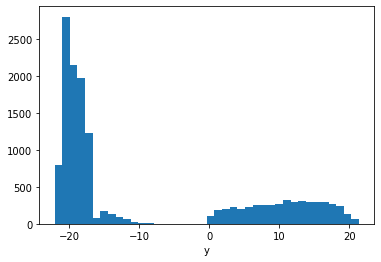

In [3]:
pl.hist(y, bins=40)
pl.xlabel('y')

Text(0, 0.5, 'y')

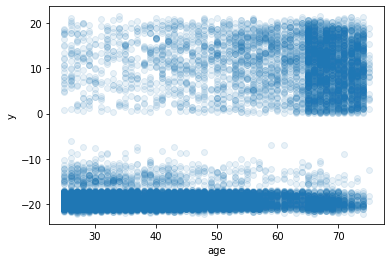

In [4]:
pl.scatter(X['age'], y, alpha=0.1)
pl.xlabel("age")
pl.ylabel("y")





## Train XGBoost model

In [5]:
# train final model on the full data set
xgb_full = xgboost.DMatrix(X, label=y)
params = {"eta": 0.002, "max_depth": 3, "objective": "survival:cox", "subsample": 0.5}
model = xgboost.train(
    params, xgb_full, 7000, evals=[(xgb_full, "test")], verbose_eval=1000
)

[0]	test-cox-nloglik:9.28404
[1000]	test-cox-nloglik:8.60868
[2000]	test-cox-nloglik:8.53134
[3000]	test-cox-nloglik:8.49490
[4000]	test-cox-nloglik:8.47122
[5000]	test-cox-nloglik:8.45325
[6000]	test-cox-nloglik:8.43787
[6999]	test-cox-nloglik:8.42367


In [6]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

#### 1. What are the most important features?

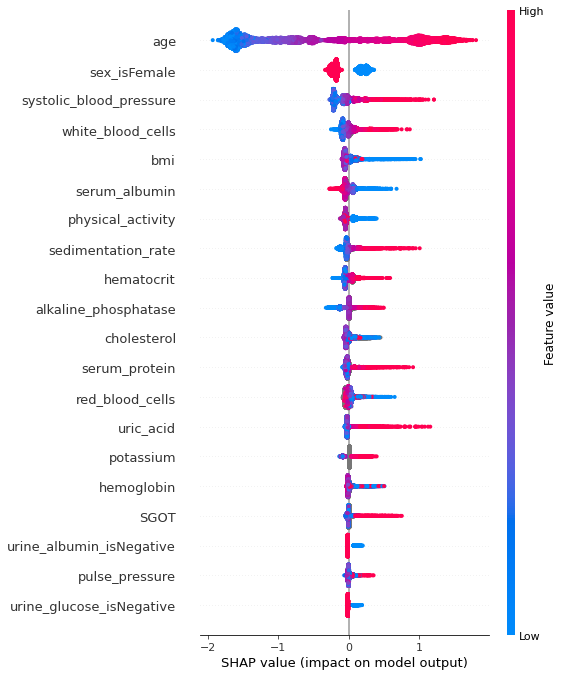

In [ ]:
shap.summary_plot(shap_values, X)

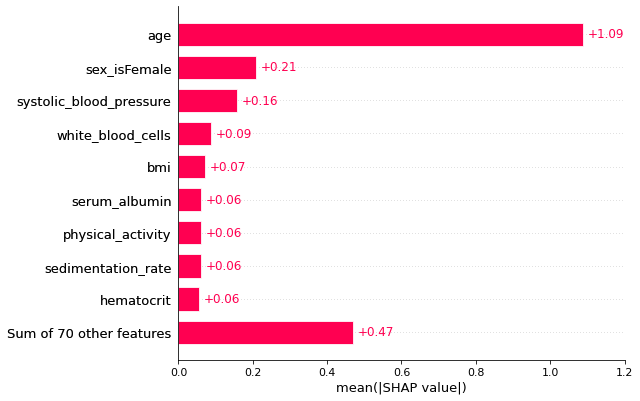

In [ ]:
shap.plots.bar(shap_values)

#### 2. What are the most important couples of features?

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X[:20])

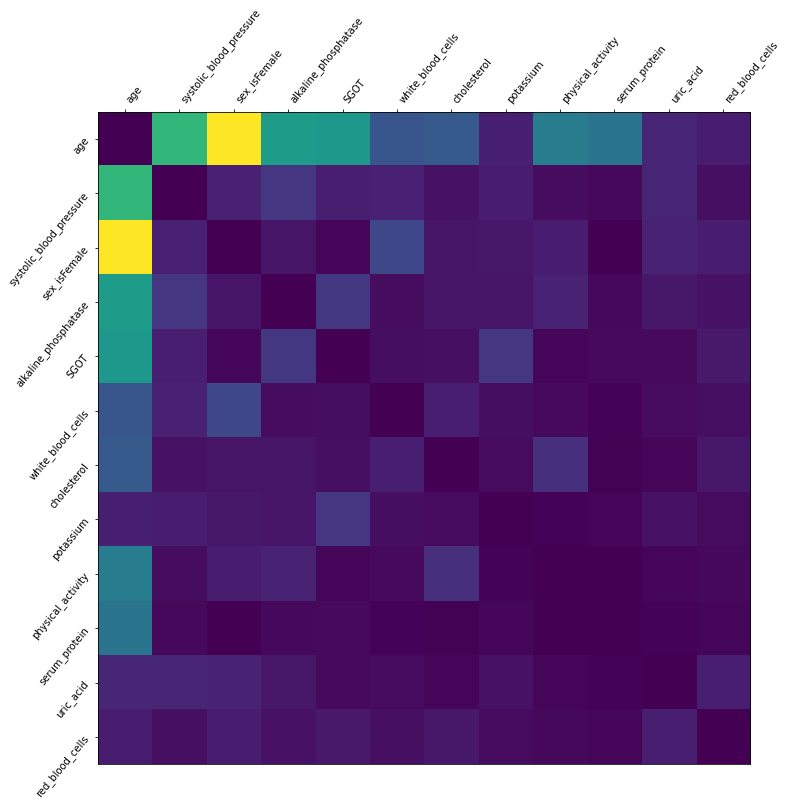

In [ ]:
interaction_matrix = np.abs(shap_interaction_values).mean(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:12]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
pl.figure(figsize=(12, 12))
pl.imshow(sorted_ia_matrix)
pl.yticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
pl.xticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
pl.gca().xaxis.tick_top()
pl.show()

#### 3. Which features have an highly non-linear contribution? Are there features that are not much correlated with the output, but that have generally an high shap value?

Features that are both relevant and non-linear are those that have an high shap value in absolute value, and that are not much linearly correlated with their shap value

In [ ]:
shap_mean_abs = np.mean(abs(shap_values.values), axis=0)

def std_or_1(x, axis=0):
    std = np.std(x, axis=axis)
    return np.where(std == 0, 1.0, std)

def safe_normalize(x):
    return (x - np.mean(x, axis=0)) / std_or_1(x, axis=0)

def elementwise_corrcoeff(a, b):
    return np.nanmean(safe_normalize(a) * safe_normalize(b), axis=0)

shap_feature_corr = elementwise_corrcoeff((shap_values.data*1).astype(np.float32), shap_values.values)

df_features = pd.DataFrame({'shap_mean_abs': shap_mean_abs, 'shap_feature_corr': shap_feature_corr}, index=X.columns)

/tmp/ipykernel_7458/3445822226.py:11: RuntimeWarning: Mean of empty slice
  return np.nanmean(safe_normalize(a) * safe_normalize(b), axis=0)


In [ ]:
df_features = df_features.dropna().sort_values('shap_mean_abs', ascending=False)
df_features[abs(df_features.shap_feature_corr) < 0.9]

,shap_mean_abs,shap_feature_corr
systolic_blood_pressure,0.157144,0.889164
bmi,0.071495,-0.294286
physical_activity,0.060215,-0.567248
urine_hematest_isNegative,0.001835,0.887876
total_bilirubin_isTestnotdone,0.000381,-0.810657
alkaline_phosphatase_isTestnotdone,0.000336,0.873692
white_blood_cells_isUnacceptable,0.000299,-0.827247
urine_glucose_isBlankbutapplicable,0.000218,-0.883481
urine_hematest_isModerate,0.000147,0.830796
creatinine_isUnacceptable,0.000104,-0.851950


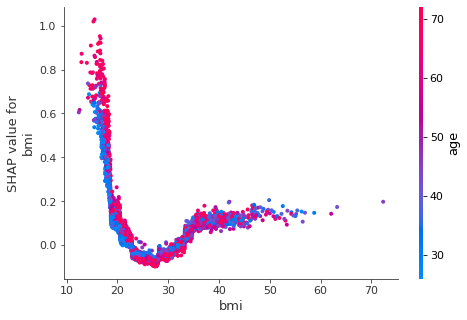

In [ ]:
shap.dependence_plot("bmi", shap_values.values, X)

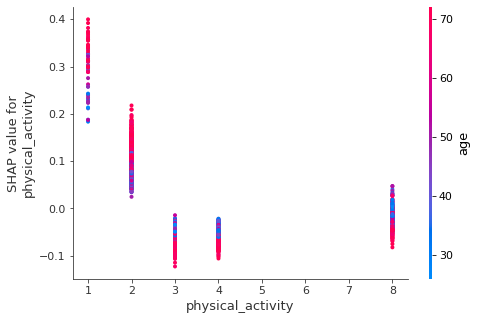

In [ ]:
shap.dependence_plot("physical_activity", shap_values.values, X)

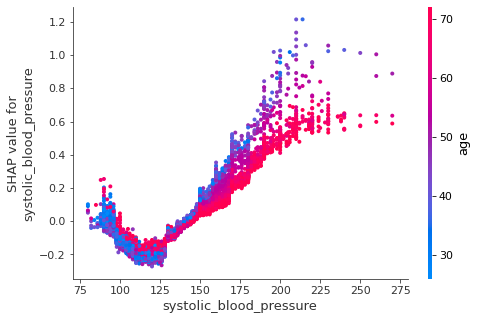

In [ ]:
shap.dependence_plot("systolic_blood_pressure", shap_values.values, X)

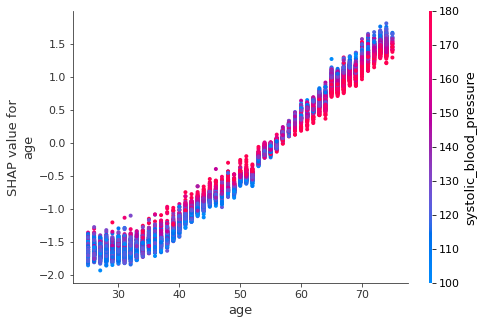

In [ ]:
shap.dependence_plot("age", shap_values.values, X)

#### 4. Compare the shap values obtained in the following different ways:
####	- Tree with TreeExplainer vs tree with KernelExplainer
####	- Tree with normalized features vs tree with unnormalized features

In [ ]:
# Tree vs Kernel explainer
N = 100
colnames = X.columns.to_list()
def tree_predict(x):
    return model.predict(xgboost.DMatrix(x, feature_names=colnames))

kernel_explainer = shap.KernelExplainer(tree_predict, data=shap.sample(X, 100))
shap_values_kernel = kernel_explainer(X[:N])

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
np.corrcoef(shap_values.values[:N].flatten(), shap_values_kernel.values[:N].flatten())

array([[1.        , 0.91983867],
       [0.91983867, 1.        ]])

In [ ]:
# Normalized features
X_norm = (X - X.mean() / X.std())

xgb_full_norm = xgboost.DMatrix(X_norm, label=y)

model_norm = xgboost.train(
    params, xgb_full_norm, 5000, evals=[(xgb_full_norm, "test")], verbose_eval=1000
)

[0]	test-cox-nloglik:9.28404
[1000]	test-cox-nloglik:8.60868
[2000]	test-cox-nloglik:8.53134
[3000]	test-cox-nloglik:8.49490
[4000]	test-cox-nloglik:8.47122
[4999]	test-cox-nloglik:8.45328


In [ ]:
explainer_norm = shap.TreeExplainer(model_norm)
shap_values_norm = explainer_norm(X_norm)

In [ ]:
np.corrcoef(shap_values.values.flatten(), shap_values_norm.values.flatten())

array([[1.       , 0.8605287],
       [0.8605287, 1.       ]])

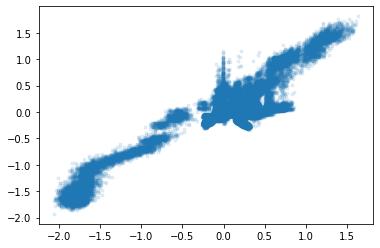

In [ ]:
pl.plot(shap_values_norm.values.flatten(), shap_values.values.flatten(), '.', alpha=0.1)

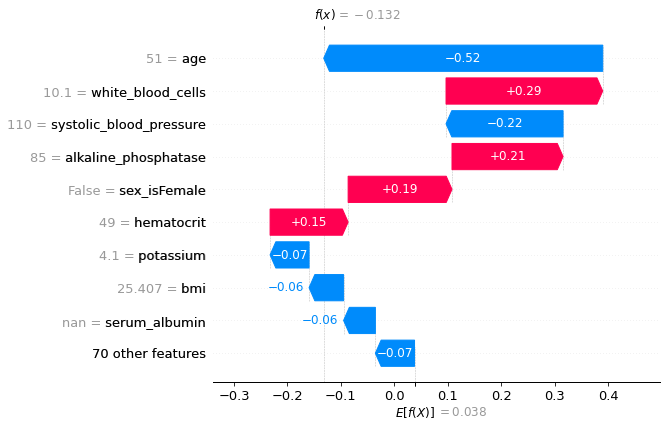

In [ ]:
shap.plots.waterfall(shap_values[0])

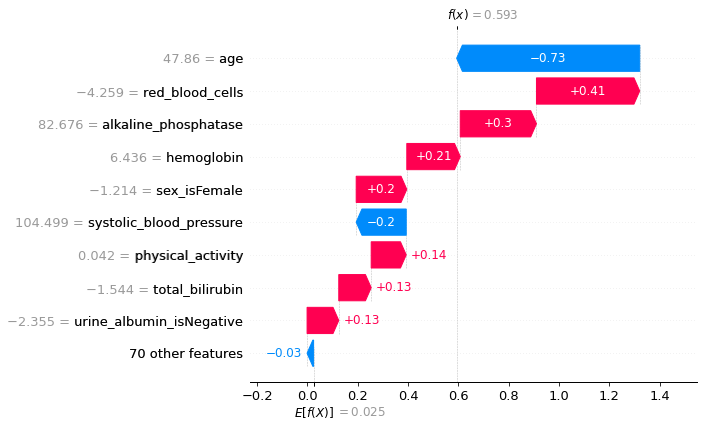

In [ ]:
shap.plots.waterfall(shap_values_norm[0])

#### 6. Let's assume SHAP values have causal meaning, find the person who can benefit the most from: 
####    - doing more physical activity
####    - acting on weight
####    - losing weight
####    - both acting on physical activity and weight
####    - acting on all characteristics that can be changed reasonably

In [ ]:
# filter characteristics: should be changeable and causes, not consequences of the predicted variable.
# seek for great effect with small intervention -> big and negative shap values
unchangeable = ['sex_isFemale', 'age']
unchangeable_indexes = [0,1]

,sex_isFemale,age,physical_activity,serum_albumin,alkaline_phosphatase,alkaline_phosphatase_isUnacceptable,alkaline_phosphatase_isTestnotdone,SGOT,SGOT_isUnacceptable,SGOT_isTestnotdone,...,urine_hematest_isLarge,urine_hematest_isBlankbutapplicable,sedimentation_rate,sedimentation_rate_isBlankbutapplicable,uric_acid,uric_acid_isUnacceptable,uric_acid_isTestnotdone,systolic_blood_pressure,pulse_pressure,bmi
20751,False,51,3,NaN,85.0,False,False,NaN,True,False,...,False,False,NaN,False,6.2,False,False,110.0,40.0,25.406803
20753,False,41,2,NaN,68.0,False,False,2.27,False,False,...,False,False,NaN,False,7.7,False,False,136.0,54.0,24.588331
20754,True,31,2,NaN,61.0,False,False,1.86,False,False,...,False,False,NaN,False,4.9,False,False,110.0,24.0,23.756502
20755,False,48,2,NaN,58.0,False,False,NaN,True,False,...,False,False,NaN,False,8.4,False,False,126.0,36.0,28.610011
20756,True,29,3,NaN,37.0,False,False,1.69,False,False,...,False,False,NaN,False,4.3,False,False,98.0,36.0,19.216489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25043,True,63,2,NaN,86.0,False,False,2.24,False,False,...,False,False,NaN,False,7.2,False,False,150.0,65.0,35.425033
25046,True,56,2,NaN,65.0,False,False,2.31,False,False,...,False,False,NaN,False,5.1,False,False,98.0,38.0,22.069132
25049,True,47,2,NaN,46.0,False,False,1.93,False,False,...,False,False,NaN,False,3.2,False,False,108.0,28.0,17.915199
25057,True,61,8,NaN,75.0,False,False,2.29,False,False,...,False,False,NaN,False,6.8,False,False,180.0,68.0,27.331622


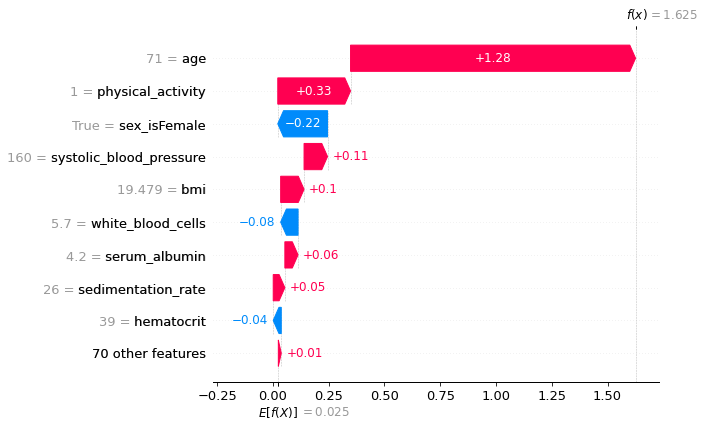

In [ ]:
# Who can benefit the most from doing more physical activity
i = shap_values.values[:,2].argmax()
shap.plots.waterfall(shap_values[i])

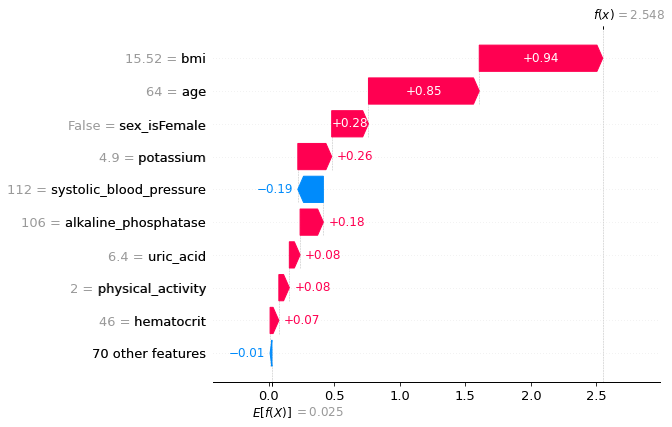

In [ ]:
# Who can benefit the most from changing weight
i = shap_values.values[:,-1].argmax()
shap.plots.waterfall(shap_values[i])

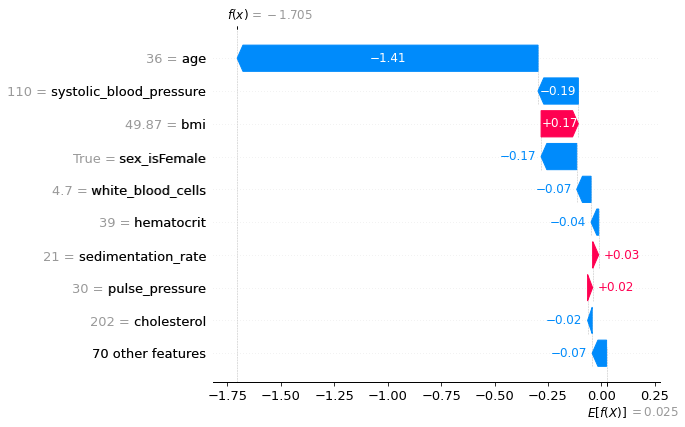

In [ ]:
# Who can benefit the most from losing weight
overweight = X[['bmi']] >= 25.0
overweight_shap_values = shap_values[overweight.to_numpy().squeeze()]
i = overweight_shap_values.values[:,-1].argmax()
shap.plots.waterfall(overweight_shap_values[i])

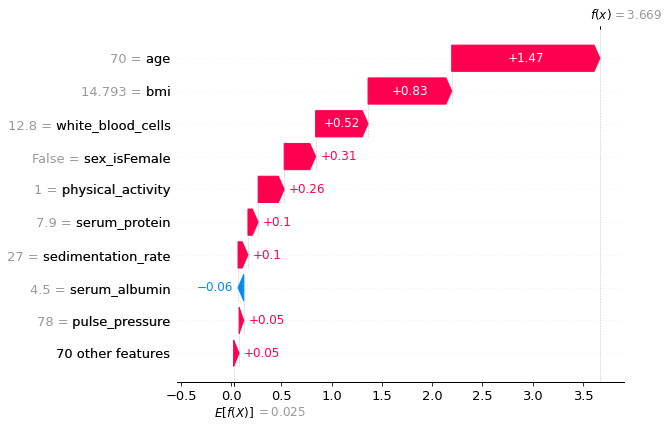

In [ ]:
# What person can benefit the most from weight changes and doing more physical activity?
subset = X['age'] < 100.0
subset_shap_values = shap_values[subset.to_numpy()]
i = (subset_shap_values.values[:,-1] + subset_shap_values.values[:,2]).argmax()
shap.plots.waterfall(subset_shap_values[i])

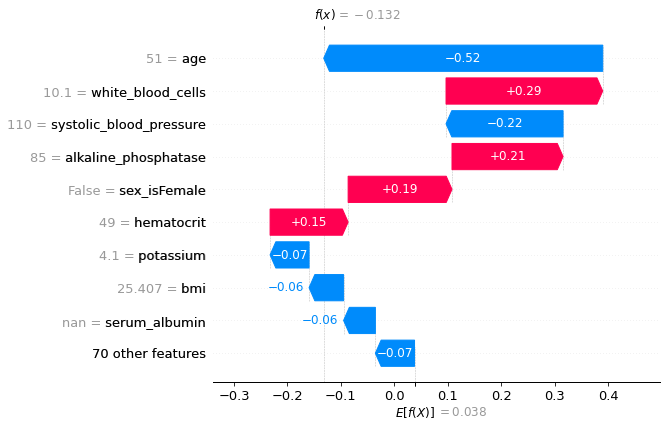

In [ ]:
# What person can benefit the most from possible changes?
def relu(x):
    return np.maximum(0, x)

i = relu(shap_values.values[:,2:].sum()).argmax()
shap.plots.waterfall(shap_values[i])